In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import scipy
import sys
sys.path.append("..")
import bayesian_anova

In [2]:
cols = ['experiment_name',
        'test_acc',
        'train_time',
        'entropy__auc',
        'entropy_expectation__auc',
        'classifier__auc']

In [3]:
experiments = ['convolutional', 'convolutional-dropout']

In [4]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_with_unknown.csv')
    df_with_results = df_with[cols].set_index('experiment_name') #df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_out_unknown.csv')
    df_without_results = df_without[cols].set_index('experiment_name') #df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [5]:
results_cols = ['experiment',
                'in_test_acc', 'out_test_acc',
                'in_train_time', 'out_train_time',
                'in_entropy_auc', 'out_entropy_auc',
                'in_entropy_expectation_auc', 'out_entropy_expectation_auc',
                'in_classifier_auc', 'out_classifier_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            str(in_key),
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
            in_row[3], out_row[3],
            in_row[4], out_row[4],
        ]
    dfs_results.append([exp, results])

In [6]:
final_results_cols = ['experiment']
for c in results_cols[1:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [7]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        
    _, *row = key_row[0]
    new_row = [row[0]]
    
    for c in range(1, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [8]:
model = pystan.StanModel(model_code=bayesian_anova.one_way_code)

In [14]:
out_acc = ['convolutional_out_classifier_auc', 'convolutional-dropout_out_classifier_auc']
#out_acc = ['convolutional_out_entropy_auc', 'convolutional-dropout_out_entropy_auc']
y_out = final_results[out_acc].values
y_out = scipy.special.logit(y_out)

in_acc = ['convolutional_in_classifier_auc', 'convolutional-dropout_in_classifier_auc']
#in_acc = ['convolutional_in_entropy_auc', 'convolutional-dropout_in_entropy_auc']
y_in = final_results[in_acc].values
y_in = scipy.special.logit(y_in)

Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.37  4.6e-4   0.03   1.31   1.35   1.36   1.38   1.42   4000    1.0
theta_free[0]     -0.02  4.5e-4   0.03  -0.08  -0.04  -0.02-9.7e-4   0.03   4000    1.0
sigma_likelihood   0.41  3.3e-4   0.02   0.37    0.4   0.41   0.42   0.45   4000    1.0
sigma_theta        5.63    0.29  18.65 7.1e-3   0.12   0.71   4.34  39.61   4000    1.0
theta[0]          -0.02  4.5e-4   0.03  -0.08  -0.04  -0.02-9.7e-4   0.03   4000    1.0
theta[1]           0.02  4.5e-4   0.03  -0.03 9.7e-4   0.02   0.04   0.08   4000    1.0
lp__              77.72    0.02    1.3   74.4  77.16  78.03  78.65  79.24   4000    1.0

Samples were drawn using NUTS(diag_e) at Thu Oct 27 11:05:16 2016.
For each parameter, n_eff is a crude m

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

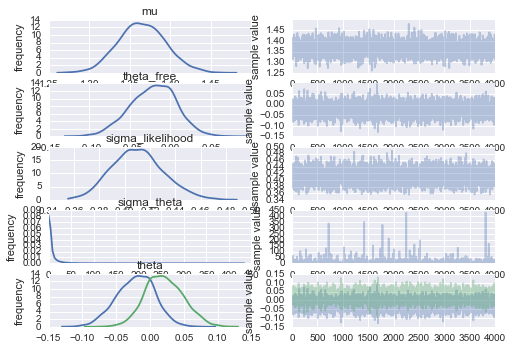

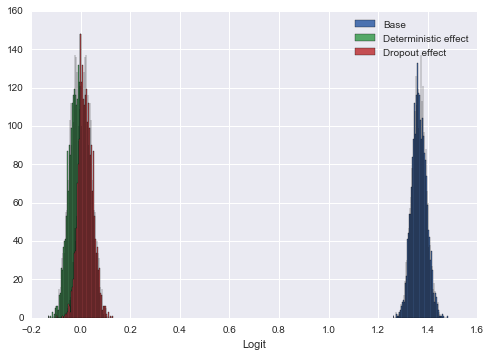

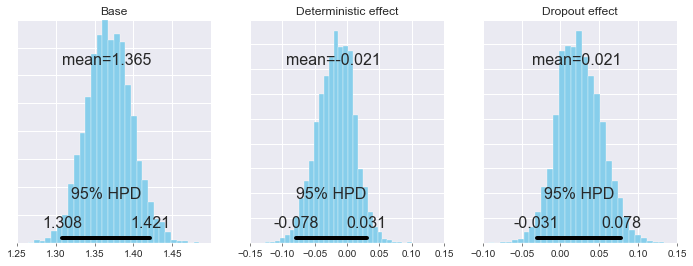

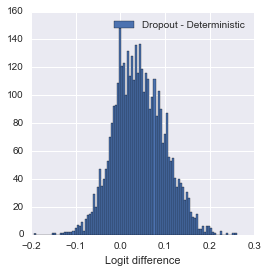

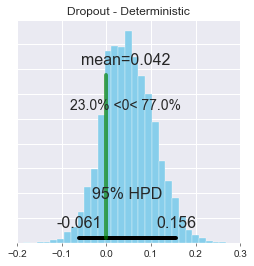

Dropout - Deterministic 95.0 CI: -0.0621098498374 0.156012038123 Pr > 0: 0.7695
Inference for Stan model: anon_model_1967665b99160b0ba8694ab613d646dd.
4 chains, each with iter=10000; warmup=5000; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                 1.06  3.1e-4   0.02   1.02   1.04   1.06   1.07   1.09   4000    1.0
theta_free[0]     -0.04  3.1e-4   0.02  -0.08  -0.05  -0.04  -0.02 9.1e-4   4000    1.0
sigma_likelihood   0.28  2.2e-4   0.01   0.25   0.27   0.28   0.28    0.3   4000    1.0
sigma_theta        6.65    0.54  34.22   0.02   0.16   0.92   5.15   43.2   4000    1.0
theta[0]          -0.04  3.1e-4   0.02  -0.08  -0.05  -0.04  -0.02 9.1e-4   4000    1.0
theta[1]           0.04  3.1e-4   0.02-9.1e-4   0.02   0.04   0.05   0.08   4000    1.0
lp__             156.88    0.02   1.33 153.56 156.25 157.21 157.84 158.45   4000    1.0

Samples were drawn using 

/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/roliveira/anaconda3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit object

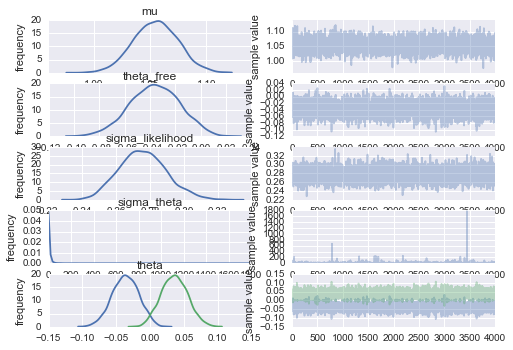

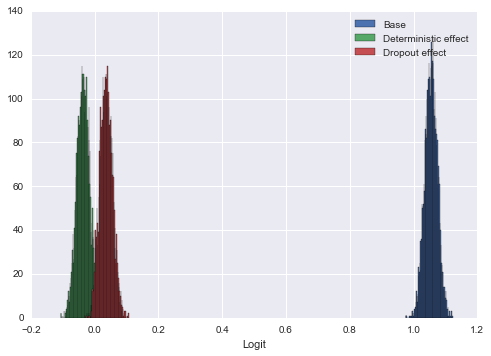

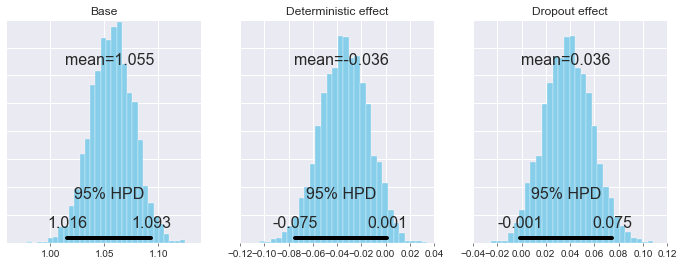

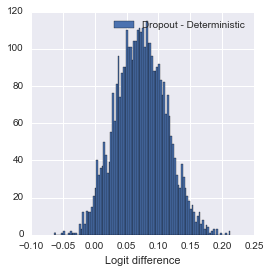

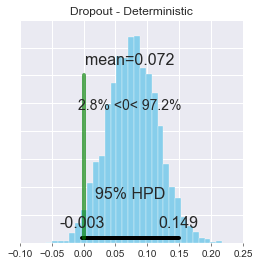

Dropout - Deterministic 95.0 CI: -0.00175040147902 0.151248210376 Pr > 0: 0.97225


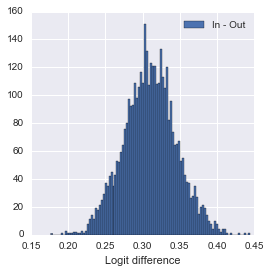

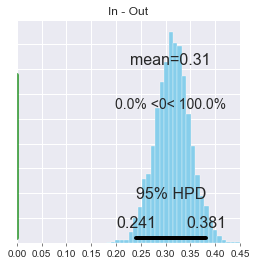

In - Out 95.0 CI: 0.240802494111 0.381399336761 Pr > 0: 1.0


In [15]:
for y in [y_in, y_out]:
    (N, K) = y.shape

    data = {'K': K, 'N': N, 'y': y}
    fit = model.sampling(data=data, iter=10000, chains=4, thin=5)
    
    bayesian_anova.show_results(fit)
    
    trace = fit.extract()
    deterministic = trace['theta'][:,0]
    dropout = trace['theta'][:,1]
    #poor_bayesian = trace['theta'][:,2]
    base_mean = trace['mu']
    
    if y is y_in:
        in_mean = np.copy(base_mean)
    else:
        out_mean = np.copy(base_mean)

    bayesian_anova.plot_traces([base_mean, deterministic, dropout],#, poor_bayesian],
                               ["Base", "Deterministic effect", "Dropout effect"])#, "Poor Bayesian effect"])

    bayesian_anova.effect_difference(dropout, deterministic, 'Dropout', 'Deterministic')
    #bayesian_anova.effect_difference(poor_bayesian, deterministic, 'Poor Bayesian', 'Deterministic')
    #bayesian_anova.effect_difference(poor_bayesian, dropout, 'Poor Bayesian', 'Dropout')

bayesian_anova.effect_difference(in_mean, out_mean, 'In', 'Out')